# HackLive - Guided Community Hackathon IV - TimeSeries
# Prophet Forecasts Stock Prices

[Link to competition here!](https://datahack.analyticsvidhya.com/contest/hacklive-4-guided-community-hackathon/)

Go there and register to be able to download the dataset and submit your predictions. Click the button below to open this notebook in Google Colab!

<a href="https://colab.research.google.com/github/jpraguer/jpraguer.github.io/master/_posts/TimeSeriesEDABaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A stock market, equity market or share market is the aggregation of buyers and sellers of stocks (also called shares), which represent ownership claims on businesses; these may include securities listed on a public stock exchange, as well as stock that is only traded privately, such as shares of private companies which are sold to investors through equity crowdfunding platforms.

The secret of a successful stock trader is being able to look into the future of the stocks and make wise decisions. Accurate prediction of stock market returns is a very challenging task due to volatile and non-linear nature of the financial stock markets. With the introduction of artificial intelligence and increased computational capabilities, programmed methods of prediction have proved to be more efficient in predicting stock prices.

 Here, you are provided dataset of a public stock market for 104 stocks. Can you forecast the future closing prices for these stocks with your Data Science skills for the next 2 months?

In [1]:
# import libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

from fbprophet import Prophet
import multiprocessing
from joblib import Parallel, delayed

In [2]:
# load data and set seed
BASE = 'https://drive.google.com/uc?export=download&id='
SEED = 2021

train = pd.read_csv(f'{BASE}1H3EhyeZ5YJi6OHjMtvWO1TpPcS-C-SYG', parse_dates=['Date']) # parse Date column right away
test = pd.read_csv(f'{BASE}1GRJpiV_fLkhE3MUPxpDcdQ-Xz-4OFKcN', parse_dates=['Date'])
ss = pd.read_csv(f'{BASE}1kOhLBDZyeONgF1NmVnc2Q2bq847VGm_V')

## EDA
First we look at the first few rows of the train and test dataset. Also double check that dates were parsed correctly.

In [3]:
train.head()

,ID,stock,Date,Open,High,Low,Close,holiday,unpredictability_score
0,id_0,0,2017-01-03,82.9961,82.7396,82.9144,82.8101,1,7
1,id_1,0,2017-01-04,83.1312,83.1669,83.3779,82.9690,0,7
2,id_2,0,2017-01-05,82.6622,82.7634,82.8984,82.8578,0,7
3,id_3,0,2017-01-06,83.0279,82.7950,82.8425,82.7385,0,7
4,id_4,0,2017-01-09,82.3761,82.0828,82.1473,81.8641,0,7


In [4]:
test.head()

,ID,stock,Date,holiday,unpredictability_score
0,id_713,0,2019-11-01,0,7
1,id_714,0,2019-11-04,0,7
2,id_715,0,2019-11-05,0,7
3,id_716,0,2019-11-06,0,7
4,id_717,0,2019-11-07,0,7


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73439 entries, 0 to 73438
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      73439 non-null  object        
 1   stock                   73439 non-null  int64         
 2   Date                    73439 non-null  datetime64[ns]
 3   Open                    73439 non-null  float64       
 4   High                    73439 non-null  float64       
 5   Low                     73439 non-null  float64       
 6   Close                   73439 non-null  float64       
 7   holiday                 73439 non-null  int64         
 8   unpredictability_score  73439 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(1)
memory usage: 5.0+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4223 entries, 0 to 4222
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      4223 non-null   object        
 1   stock                   4223 non-null   int64         
 2   Date                    4223 non-null   datetime64[ns]
 3   holiday                 4223 non-null   int64         
 4   unpredictability_score  4223 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 165.1+ KB


In [7]:
# define ID and target column names
ID_COL, TARGET_COL = 'ID', 'Close'

# define predictors
features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]

In [8]:
# look at train and test sizes
train.shape, test.shape

((73439, 9), (4223, 5))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



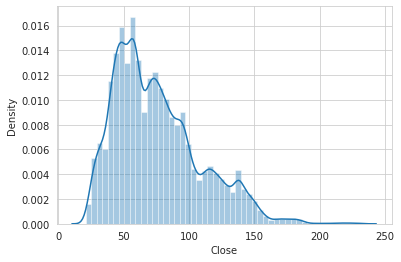

In [9]:
# plot target distribution
sns.distplot(train[TARGET_COL]);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



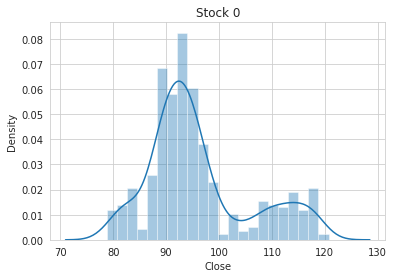

In [10]:
# plot target distribution for a single stock
STOCK_NO = 0
sns.distplot(train.loc[train['stock'] == STOCK_NO, TARGET_COL]).set_title(f'Stock {STOCK_NO}');

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



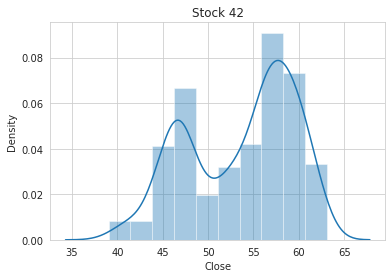

In [11]:
# plot target distribution for a different stock
STOCK_NO = 42
sns.distplot(train.loc[train['stock'] == STOCK_NO, TARGET_COL]).set_title(f'Stock {STOCK_NO}');

In [12]:
# unique values in each variable
train.nunique()

ID                        73439
stock                       103
Date                        713
Open                      60702
High                      60594
Low                       61015
Close                     60352
holiday                       2
unpredictability_score       10
dtype: int64

In [13]:
test.nunique()

ID                        4223
stock                      103
Date                        41
holiday                      2
unpredictability_score      10
dtype: int64

0    69216
1     4223
Name: holiday, dtype: int64


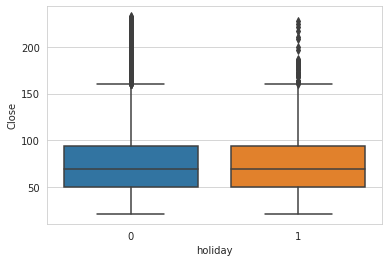

In [14]:
# explore holiday variable
print(train['holiday'].value_counts())
sns.boxplot(x = train['holiday'], y = train[TARGET_COL]);

9    7843
4    7843
0    7843
8    7130
7    7130
6    7130
5    7130
3    7130
2    7130
1    7130
Name: unpredictability_score, dtype: int64


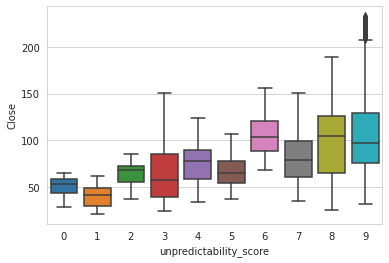

In [15]:
# explore unpredictability_score
print(train['unpredictability_score'].value_counts())
sns.boxplot(x = train['unpredictability_score'], y = train[TARGET_COL]);

In [16]:
# date ranges
print(train['Date'].min(), train['Date'].max())
print(test['Date'].min(), test['Date'].max())

2017-01-03 00:00:00 2019-10-31 00:00:00
2019-11-01 00:00:00 2019-12-31 00:00:00


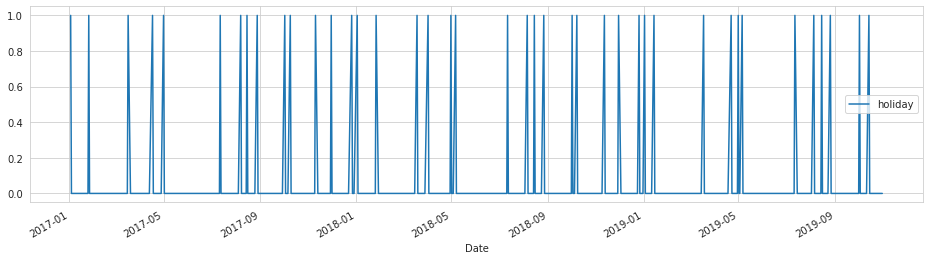

In [17]:
# plot holidays in train
train.set_index('Date')[['holiday']].plot(figsize=(16, 4));

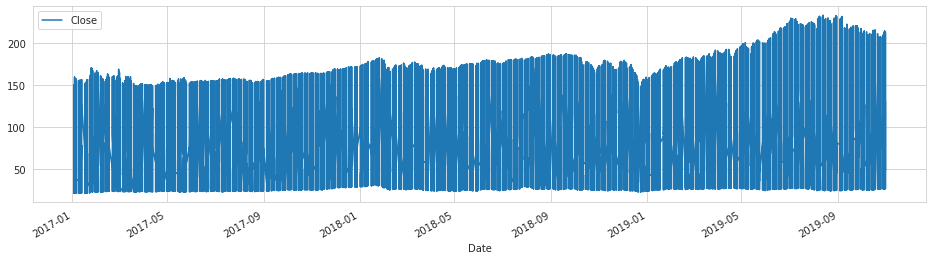

In [18]:
# plot Close
train.set_index('Date')[[TARGET_COL]].plot(figsize=(16, 4));

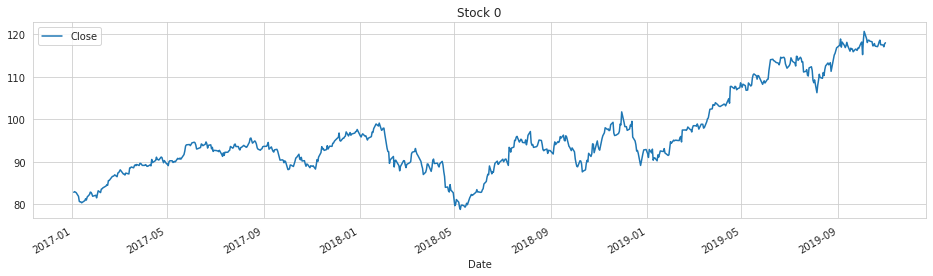

In [19]:
# plot Close for a single stock
STOCK_NO = 0
train.loc[train['stock'] == STOCK_NO].set_index('Date')[[TARGET_COL]].plot(figsize=(16, 4), title = f'Stock {STOCK_NO}');

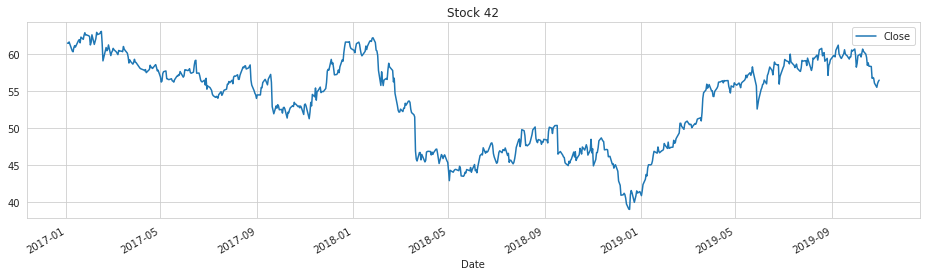

In [20]:
# plot Close for a different stock
STOCK_NO = 42
train.loc[train['stock'] == STOCK_NO].set_index('Date')[[TARGET_COL]].plot(figsize=(16, 4), title = f'Stock {STOCK_NO}');

#### Observations
No null values in these datasets. Training dates are from January 2017 to Halloween 2019, test dates are November and December 2019.
We should predict future stock price for 104 different stocks based only on `Date`, `holiday` flag (1/0) and an `unpredictability_score` (1-9).
Closing amount does not seem to differ too much on `holiday`s compared to normal days. Volatility definitely rises with increasing `unpredictability_score`, as expected. Counts in each score are quite balanced, with 9, 4, and 0 being slightly more common - worth more exploration in the future.

## Baseline FB Prophet model!
Let's define a parallelised Prophet prediction pipeline to speed up the prediction for 104 stocks separately.
Credit for this idea goes to [this kaggle kernel](https://www.kaggle.com/raghvenbhati/prophet-forecasts).

In [21]:
# Forecast function:
def ProphetFC(stock_no: int):
    '''
    Predict test prices for each stock separately.

    :param stock_no: Stock ID to predict
    
    :returns: Forecasted future dataframe, as return by prophet's .predict method
    '''
    # Create Prophet model
    m = Prophet()
    
    # Create df, add features and fit
    tsdf = pd.DataFrame({
      'ds': train.loc[train['stock'] == stock_no, 'Date'].reset_index(drop=True),
      'y': train.loc[train['stock'] == stock_no, TARGET_COL].reset_index(drop=True),
    })
    tsdf['holiday'] = train.loc[train['stock'] == stock_no, 'holiday'].reset_index(drop=True)
    tsdf['unpredictability_score'] = train.loc[train['stock'] == stock_no, 'unpredictability_score'].reset_index(drop=True)
    
    m.add_regressor('holiday')
    m.add_regressor('unpredictability_score')

    m.fit(tsdf)
    
    # create future df and predict
    future = pd.DataFrame({
      'ds': test.loc[test['stock'] == stock_no, 'Date'].reset_index(drop=True),
    })

    future['holiday'] = test.loc[test['stock'] == stock_no, 'holiday'].reset_index(drop=True)
    future['unpredictability_score'] = test.loc[test['stock'] == stock_no, 'unpredictability_score'].reset_index(drop=True)

    fcst = m.predict(future)

    fcst[ID_COL] = test.loc[test['stock'] == stock_no, ID_COL]
    
    fcst['stock'] = stock_no
    return fcst

In [22]:
%%time
# how many stocks to predict for
NUM_STOCKS = train['stock'].nunique()

# parallel jobs to forecast
num_cores = multiprocessing.cpu_count()
processed_FC = Parallel(n_jobs=num_cores)(delayed(ProphetFC)(i) for i in range(NUM_STOCKS))

CPU times: user 3 s, sys: 160 ms, total: 3.16 s
Wall time: 5min 15s


In [23]:
# combining obtained dataframes
FCAST = pd.concat(processed_FC, ignore_index=True)
FCAST.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,holiday,holiday_lower,holiday_upper,unpredictability_score,unpredictability_score_lower,unpredictability_score_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,ID,stock
0,2019-11-01,123.836651,117.992600,122.187867,123.836651,123.836651,-3.858359,-3.858359,-3.858359,-0.083126,-0.083126,-0.083126,0.0,0.0,0.0,-0.083126,-0.083126,-0.083126,0.098074,0.098074,0.098074,-3.873307,-3.873307,-3.873307,0.0,0.0,0.0,119.978292,id_713,0
1,2019-11-04,124.158461,118.541425,122.710671,124.158461,124.158461,-3.492853,-3.492853,-3.492853,-0.083126,-0.083126,-0.083126,0.0,0.0,0.0,-0.083126,-0.083126,-0.083126,-0.073551,-0.073551,-0.073551,-3.336177,-3.336177,-3.336177,0.0,0.0,0.0,120.665608,id_714,0
2,2019-11-05,124.265731,118.865930,123.259751,124.265731,124.265731,-3.231049,-3.231049,-3.231049,-0.083126,-0.083126,-0.083126,0.0,0.0,0.0,-0.083126,-0.083126,-0.083126,-0.007098,-0.007098,-0.007098,-3.140825,-3.140825,-3.140825,0.0,0.0,0.0,121.034682,id_715,0
3,2019-11-06,124.373002,119.118231,123.431604,124.373002,124.373002,-3.067293,-3.067293,-3.067293,-0.083126,-0.083126,-0.083126,0.0,0.0,0.0,-0.083126,-0.083126,-0.083126,-0.045587,-0.045587,-0.045587,-2.938580,-2.938580,-2.938580,0.0,0.0,0.0,121.305709,id_716,0
4,2019-11-07,124.480272,119.611473,123.998805,124.480272,124.480272,-2.787002,-2.787002,-2.787002,-0.083126,-0.083126,-0.083126,0.0,0.0,0.0,-0.083126,-0.083126,-0.083126,0.026466,0.026466,0.026466,-2.730342,-2.730342,-2.730342,0.0,0.0,0.0,121.693270,id_717,0


In [24]:
# define function to plot predictions
def plot_preds(stock_no: int):
  '''
  PLot Closes for a certain stock separately.

  :param stock_no: Stock ID to plot
    
  :returns: nothing
  '''
  # create temp train df
  train_tmp = train.loc[train['stock'] == stock_no].set_index('Date')[[TARGET_COL]]
  train_tmp['type'] = 'train'

  # create temp test df
  test_tmp = FCAST.loc[FCAST['stock'] == stock_no].rename(columns={"yhat": TARGET_COL, 'ds': 'Date'}).set_index('Date')[[TARGET_COL]]
  test_tmp['type'] = 'test'
  train_tmp.append(test_tmp).groupby('type')[TARGET_COL].plot(figsize=(16, 4), title = f'Stock {stock_no}', sharex=False, legend=True);
  pass

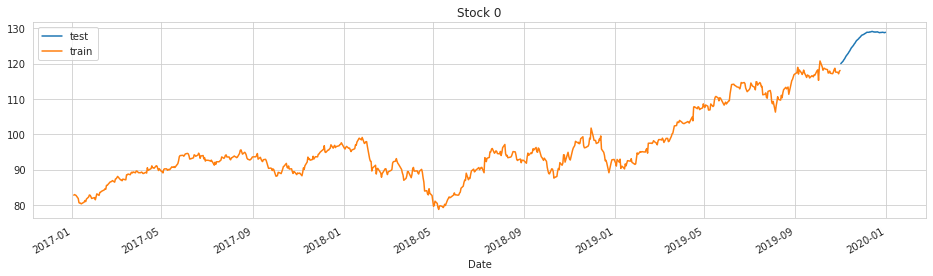

In [25]:
# plot stock 0 with preds
plot_preds(0)

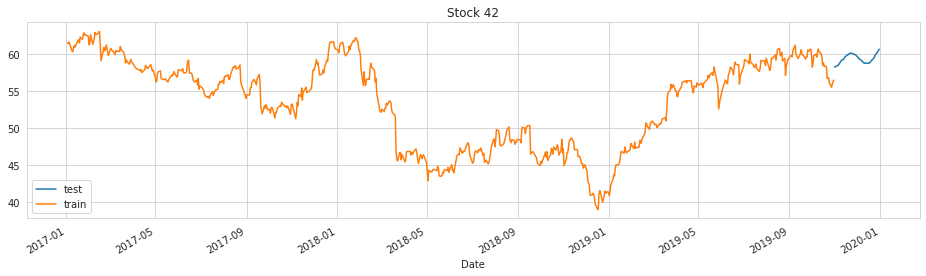

In [26]:
# plot stock 42 with preds
plot_preds(42)

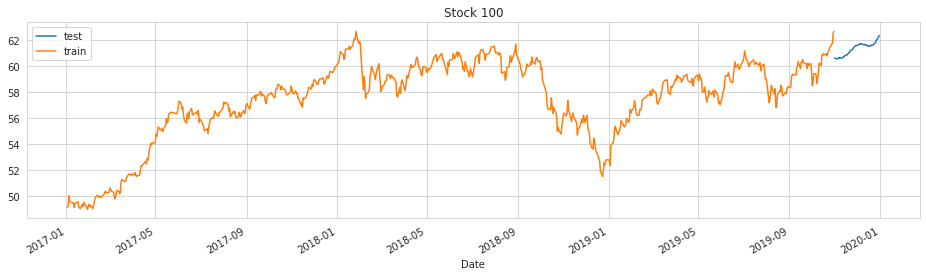

In [27]:
# plot stock 100 with preds
plot_preds(100)

#### Observations
Clearly some of these predictions do not start where the train set ends, so further iterations are needed (perhaps targeted on holidays, seasonality, and its fourier order) to fix this problem.

In [28]:
# submission
submission = FCAST[['ID', 'yhat']].rename(columns={'yhat': TARGET_COL})
submission.to_csv('submission_prophet_baseline.csv',index=False)

In [29]:
# and we're done!
'Done!'

'Done!'